In [2]:
pip install neurokit2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd

10000

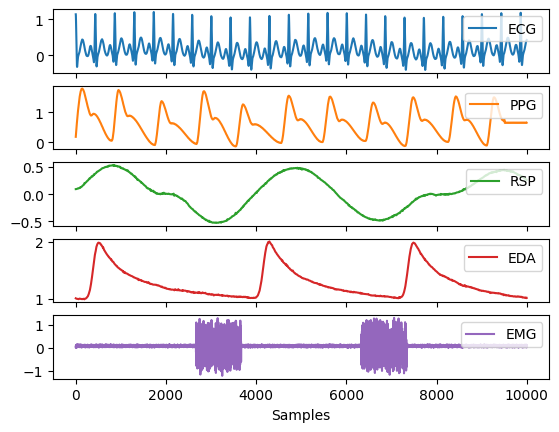

In [37]:
# Generate synthetic signals
ecg = nk.ecg_simulate(duration=10, heart_rate=140)
ppg = nk.ppg_simulate(duration=10, heart_rate=70)
rsp = nk.rsp_simulate(duration=10, respiratory_rate=15)
eda = nk.eda_simulate(duration=10, scr_number=3)
emg = nk.emg_simulate(duration=10, burst_number=2)
# Visualise biosignals
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg,
                     "RSP": rsp,
                     "EDA": eda,
                     "EMG": emg})
nk.signal_plot(data, subplots=True)
len(data)

In [39]:
ecg_cleaned = nk.ecg_clean(ecg, method="neurokit")
print(ecg_cleaned)

[-0.05852794 -0.11059027 -0.16286955 ... -0.02549358 -0.02468525
 -0.02389904]


In [38]:
_, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
print(rpeaks_info["ECG_R_Peaks"])

[ 427  854 1279 1704 2132 2563 2995 3429 3860 4287 4711 5135 5560 5988
 6420 6854 7288 7719 8147 8571 8994 9419 9847]


In [28]:
signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=1000)

In [29]:
r_peaks = info["ECG_R_Peaks"]

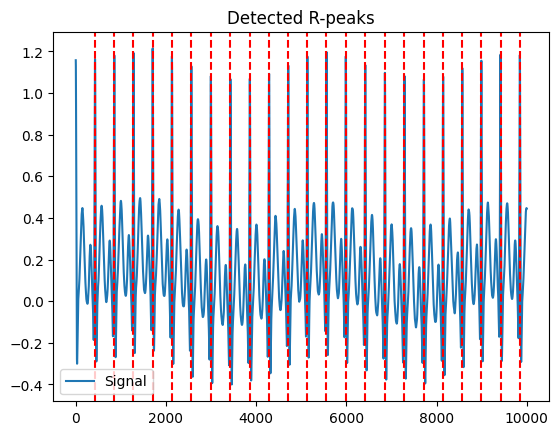

In [30]:
import matplotlib.pyplot as plt
nk.events_plot(r_peaks, ecg)
plt.title("Detected R-peaks")
plt.show()

In [31]:
# Function to calculate ST depression and slope from R-peaks
def calculate_st_depression_and_slope(ecg_signal, r_peaks, fs=1000):
    st_depressions = []
    slopes = []
    
    for r_peak in r_peaks:
        # Segment the ECG from the J-point (after QRS complex)
        st_segment = ecg_signal[r_peak + int(60 * fs / 1000): r_peak + int(80 * fs / 1000)]  # ST segment
        baseline_segment = ecg_signal[r_peak - int(200 * fs / 1000): r_peak - int(150 * fs / 1000)]  # Baseline
        
        # Calculate ST depression: difference between ST segment and baseline
        st_depression = np.mean(st_segment) - np.mean(baseline_segment)
        st_depressions.append(st_depression)
        
        # Calculate Slope: Linear regression on ST segment (time vs amplitude)
        time = np.linspace(0, len(st_segment) / fs, len(st_segment))  # Time in seconds
        slope = np.polyfit(time, st_segment, 1)[0]  # Linear fit (slope)
        
        # Classify Slope (0: Upsloping, 1: Horizontal, 2: Downsloping)
        if slope > 0:
            slopes.append(0)  # Upsloping
        elif slope == 0:
            slopes.append(1)  # Horizontal
        else:
            slopes.append(2)  # Downsloping
    
    return st_depressions, slopes

In [32]:
st_depressions, slopes = calculate_st_depression_and_slope(ecg_cleaned, r_peaks)

In [33]:
def calculate_st_depression_and_slope(ecg_cleaned, r_peaks, sampling_rate=1000):
    st_depressions = []
    slopes = []
    
    for i in range(1, len(r_peaks) - 1):
        # Define the ST segment (e.g., 60-80 ms after the R peak)
        st_start = r_peaks[i] + int(0.06 * sampling_rate)  # 60 ms after R peak
        st_end = r_peaks[i] + int(0.08 * sampling_rate)    # 80 ms after R peak

        # Calculate ST depression
        baseline = ecg_cleaned[r_peaks[i] - 20:r_peaks[i]].mean()  # Baseline as average 20 samples before R-peak
        st_depression = ecg_cleaned[st_start:st_end].mean() - baseline
        st_depressions.append(st_depression)

        # Calculate slope and categorize it into 0, 1, 2
        slope_value = ecg_cleaned[st_end] - ecg_cleaned[st_start]
        
        # Categorize slope based on thresholds
        if slope_value > 0.05:          # Adjust thresholds as needed
            slope_category = 0          # Upsloping
        elif -0.05 <= slope_value <= 0.05:
            slope_category = 1          # Horizontal
        else:
            slope_category = 2          # Downsloping

        slopes.append(slope_category)

    return st_depressions, slopes

In [35]:
average_st_depression = np.mean(st_depressions)
average_slope = np.mean(slopes)

print("Average ST Depression:", average_st_depression)
print("Slope:", average_slope)

Average ST Depression: 0.06349711721474209
Slope: 0.0
